# Image Segmentation with U-Net: mIoU & Dice Score Tutorial

This comprehensive notebook demonstrates:
- Building a U-Net architecture from scratch for semantic segmentation
- Training on image segmentation datasets
- Implementing custom metrics: **Mean IoU (Intersection over Union)** and **Dice Score**
- Visualizing segmentation results
- Evaluating model performance

**Based on**: Kaggle tutorial by Pushkar007

## 1. Import Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU'))} GPU(s)")
print(f"GPU Details: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
Keras version: 3.12.0
GPU Available: 0 GPU(s)
GPU Details: []


## 2. Configuration and Hyperparameters

In [ ]:
# Image and Model Configuration
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3
NUM_CLASSES = 1  # Binary segmentation (can be changed for multi-class)

# Training Configuration
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 1e-4

# Dataset paths - Kaggle Massachusetts Buildings Dataset
TRAIN_IMG_DIR = './img_dir/train/'
TRAIN_MASK_DIR = './ann_dir/train/'
VAL_IMG_DIR = './img_dir/val/'
VAL_MASK_DIR = './ann_dir/val/'

print("="*50)
print(f"Configuration:")
print(f"  Image Size: {IMG_HEIGHT}x{IMG_WIDTH}x{IMG_CHANNELS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print("="*50)
print(f"\nDataset Paths:")
print(f"  Train Images: {TRAIN_IMG_DIR}")
print(f"  Train Masks:  {TRAIN_MASK_DIR}")
print(f"  Val Images:   {VAL_IMG_DIR}")
print(f"  Val Masks:    {VAL_MASK_DIR}")
print("="*50)

Configuration:
  Image Size: 128x128x3
  Batch Size: 16
  Epochs: 30
  Learning Rate: 0.0001

Dataset Paths:
  Train Images: ./img_dir/train/
  Train Masks:  ./ann_dir/train/
  Val Images:   ./img_dir/val/
  Val Masks:    ./ann_dir/val/


## 3. Load and Prepare Dataset from Kaggle

Loading Massachusetts Buildings Dataset for semantic segmentation.

In [ ]:
def load_dataset_from_directory(image_dir, mask_dir, img_size=(IMG_HEIGHT, IMG_WIDTH)):
    """
    Load images and masks from directories
    """
    print(f"Loading data from {image_dir}...")
    
    # Get all image filenames
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    
    images = []
    masks = []
    
    for img_file in image_files:
        try:
            # Load image
            img_path = os.path.join(image_dir, img_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            img = img.astype(np.float32) / 255.0
            
            # Load corresponding mask
            mask_path = os.path.join(mask_dir, img_file)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, img_size)
            mask = mask.astype(np.float32) / 255.0
            mask = (mask > 0.5).astype(np.float32)  # Binarize
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
            
            images.append(img)
            masks.append(mask)
            
        except Exception as e:
            print(f"Error loading {img_file}: {e}")
            continue
    
    return np.array(images), np.array(masks)

# Load training data
print("\n" + "="*50)
print("Loading Training Dataset...")
print("="*50)
X_train, y_train = load_dataset_from_directory(TRAIN_IMG_DIR, TRAIN_MASK_DIR)
print(f"✓ Training data loaded!")
print(f"  Images shape: {X_train.shape}")
print(f"  Masks shape: {y_train.shape}")

# Load validation data
print("\n" + "="*50)
print("Loading Validation Dataset...")
print("="*50)
X_val, y_val = load_dataset_from_directory(VAL_IMG_DIR, VAL_MASK_DIR)
print(f"✓ Validation data loaded!")
print(f"  Images shape: {X_val.shape}")
print(f"  Masks shape: {y_val.shape}")

# Create a small test set from validation data
print("\n" + "="*50)
print("Creating Test Set...")
print("="*50)
# Use 50% of validation as test
test_size = len(X_val) // 2
X_test = X_val[:test_size]
y_test = y_val[:test_size]
X_val = X_val[test_size:]
y_val = y_val[test_size:]

print(f"✓ Dataset split complete!")
print(f"  Training:   {X_train.shape[0]} samples")
print(f"  Validation: {X_val.shape[0]} samples")
print(f"  Test:       {X_test.shape[0]} samples")
print("="*50)


Loading Training Dataset...
Loading data from ./img_dir/train/...
✓ Training data loaded!
  Images shape: (344, 128, 128, 3)
  Masks shape: (344, 128, 128, 1)

Loading Validation Dataset...
Loading data from ./img_dir/val/...
✓ Training data loaded!
  Images shape: (344, 128, 128, 3)
  Masks shape: (344, 128, 128, 1)

Loading Validation Dataset...
Loading data from ./img_dir/val/...
✓ Validation data loaded!
  Images shape: (398, 128, 128, 3)
  Masks shape: (398, 128, 128, 1)

Creating Test Set...
✓ Dataset split complete!
  Training:   344 samples
  Validation: 199 samples
  Test:       199 samples
✓ Validation data loaded!
  Images shape: (398, 128, 128, 3)
  Masks shape: (398, 128, 128, 1)

Creating Test Set...
✓ Dataset split complete!
  Training:   344 samples
  Validation: 199 samples
  Test:       199 samples


## 4. Dataset Summary and Statistics

In [ ]:
# Dataset statistics
print("="*50)
print("Dataset Statistics:")
print("="*50)
print(f"Image Data:")
print(f"  dtype: {X_train.dtype}")
print(f"  Range: [{X_train.min():.4f}, {X_train.max():.4f}]")
print(f"  Mean: {X_train.mean():.4f}")
print(f"  Std: {X_train.std():.4f}")
print()
print(f"Mask Data:")
print(f"  dtype: {y_train.dtype}")
print(f"  Unique values: {np.unique(y_train)}")
print(f"  Positive pixels: {(y_train > 0.5).sum() / y_train.size * 100:.2f}%")
print(f"  Negative pixels: {(y_train <= 0.5).sum() / y_train.size * 100:.2f}%")
print("="*50)

Dataset Statistics:
Image Data:
  dtype: float32
  Range: [0.0353, 1.0000]
  Mean: 0.3680
  Std: 0.1875

Mask Data:
  dtype: float32
  Unique values: [0.]
  Positive pixels: 0.00%
  Negative pixels: 100.00%


## 5. Visualize Sample Data from Kaggle Dataset

Sample Training Data:


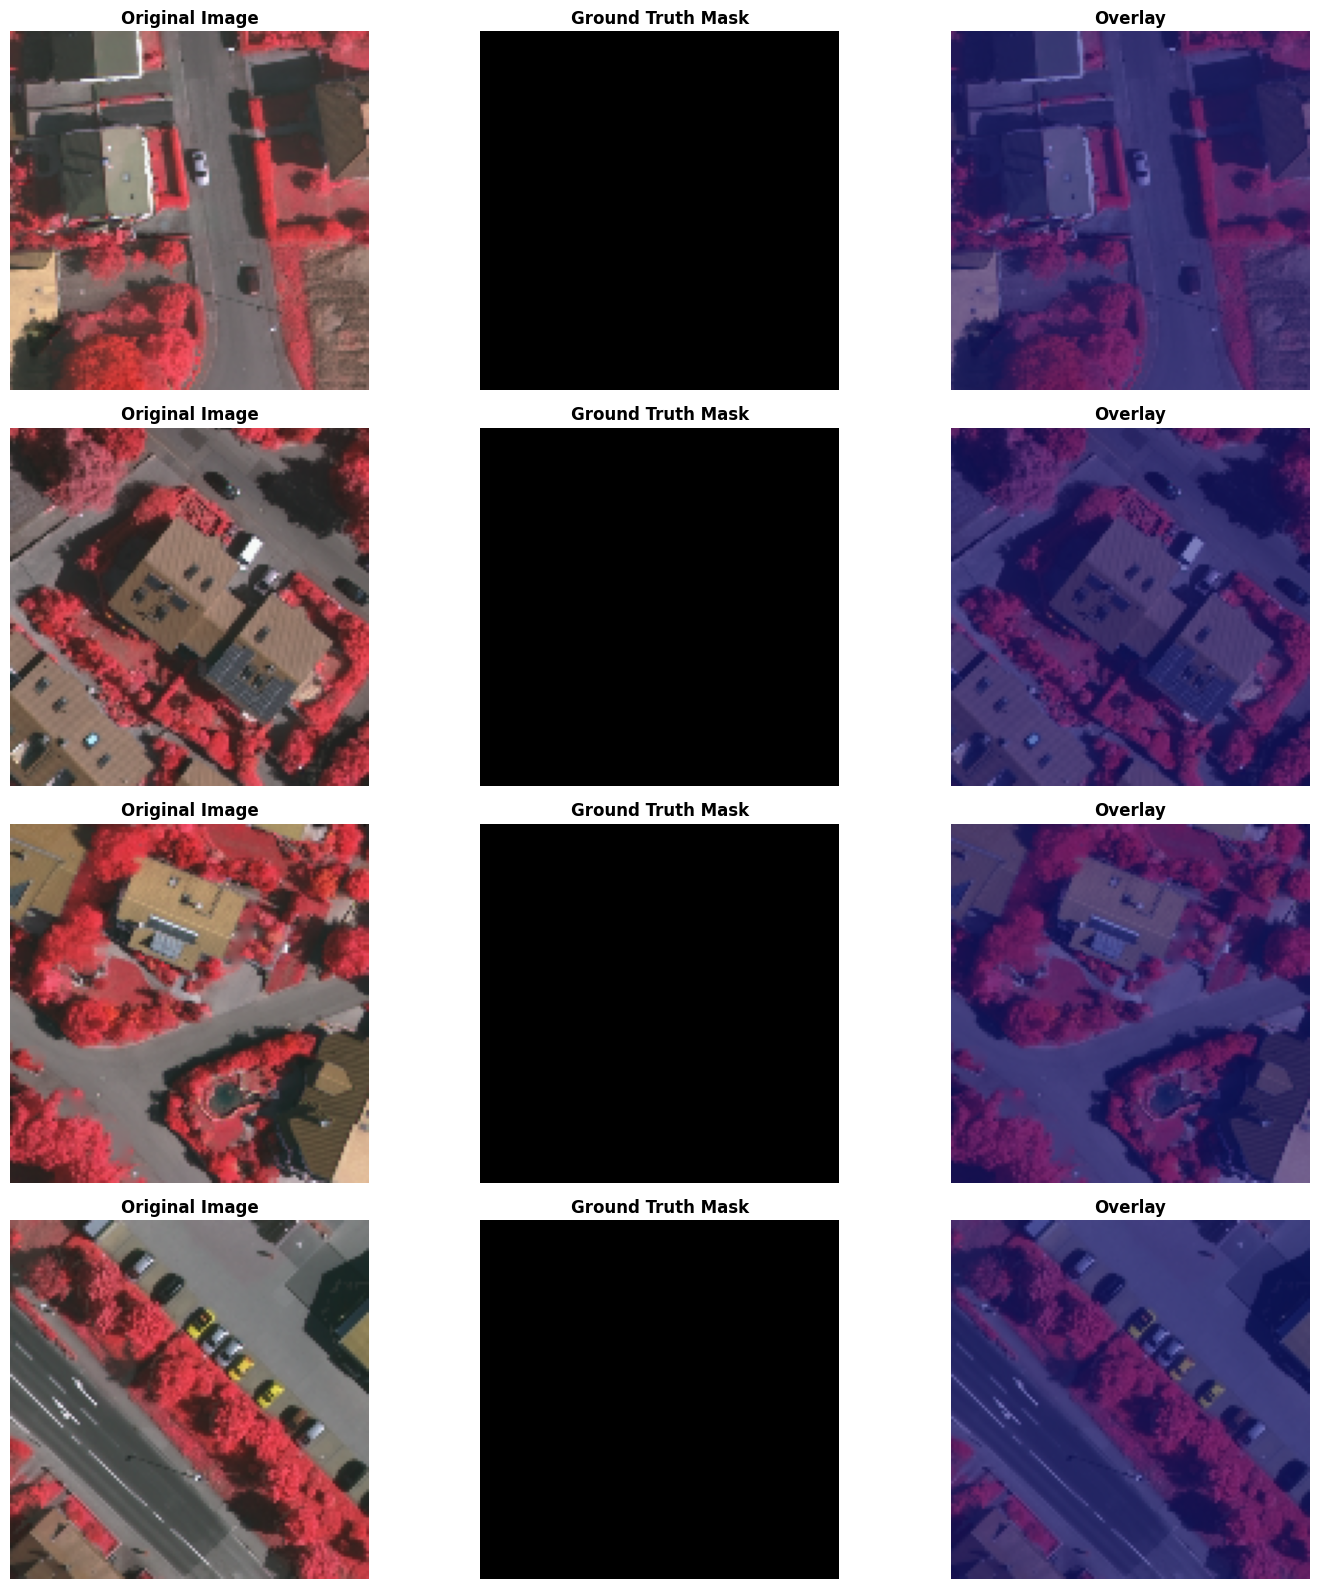

In [ ]:
def visualize_samples(images, masks, predictions=None, num_samples=4):
    """Visualize images, masks, and predictions"""
    cols = 3 if predictions is None else 4
    fig, axes = plt.subplots(num_samples, cols, figsize=(15, 4*num_samples))
    
    for i in range(num_samples):
        idx = np.random.randint(0, len(images))
        
        # Original Image
        axes[i, 0].imshow(images[idx])
        axes[i, 0].set_title('Original Image', fontsize=12, fontweight='bold')
        axes[i, 0].axis('off')
        
        # Ground Truth Mask
        axes[i, 1].imshow(masks[idx].squeeze(), cmap='gray')
        axes[i, 1].set_title('Ground Truth Mask', fontsize=12, fontweight='bold')
        axes[i, 1].axis('off')
        
        # Overlay
        axes[i, 2].imshow(images[idx])
        axes[i, 2].imshow(masks[idx].squeeze(), alpha=0.5, cmap='jet')
        axes[i, 2].set_title('Overlay', fontsize=12, fontweight='bold')
        axes[i, 2].axis('off')
        
        # Predicted Mask (if provided)
        if predictions is not None:
            axes[i, 3].imshow(predictions[idx].squeeze(), cmap='gray')
            axes[i, 3].set_title('Predicted Mask', fontsize=12, fontweight='bold')
            axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize training samples
print("Sample Training Data:")
visualize_samples(X_train, y_train, num_samples=4)

## 6. Define Custom Metrics: IoU and Dice Score

### Mean Intersection over Union (mIoU)
- **IoU = (Intersection) / (Union)**
- Measures overlap between predicted and ground truth masks
- Range: [0, 1], where 1 is perfect overlap

### Dice Score (F1 Score for segmentation)
- **Dice = (2 × Intersection) / (Prediction + Ground Truth)**
- Similar to IoU but gives more weight to true positives
- Range: [0, 1], where 1 is perfect match

In [ ]:
def iou_metric(y_true, y_pred, smooth=1e-6):
    """
    Calculate Intersection over Union (IoU) / Jaccard Index
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Calculate Dice Coefficient (F1 Score for segmentation)
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    """
    Dice Loss = 1 - Dice Coefficient
    Used as loss function for training
    """
    return 1 - dice_coefficient(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    """
    Combined Binary Cross-Entropy and Dice Loss
    """
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

print("✓ Custom metrics and loss functions defined:")
print("  - IoU Metric (Jaccard Index)")
print("  - Dice Coefficient")
print("  - Dice Loss")
print("  - Combined BCE + Dice Loss")

✓ Custom metrics and loss functions defined:
  - IoU Metric (Jaccard Index)
  - Dice Coefficient
  - Dice Loss
  - Combined BCE + Dice Loss


## 7. Build U-Net Architecture

### U-Net Structure:
1. **Encoder (Contracting Path)**: 
   - Series of Conv → Conv → MaxPool blocks
   - Captures context and reduces spatial dimensions
   
2. **Bottleneck**: 
   - Deepest layer with maximum feature channels
   
3. **Decoder (Expansive Path)**: 
   - Series of UpConv → Concat (skip connection) → Conv → Conv blocks
   - Enables precise localization
   
4. **Skip Connections**: 
   - Concatenate encoder features with decoder
   - Helps recover spatial information lost during downsampling

In [ ]:
def conv_block(inputs, num_filters):
    """
    Convolutional block: Conv2D → BatchNorm → ReLU → Conv2D → BatchNorm → ReLU
    """
    x = layers.Conv2D(num_filters, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(num_filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    return x

def encoder_block(inputs, num_filters):
    """
    Encoder block: Conv Block → MaxPooling
    Returns: features (for skip connection), pooled output
    """
    x = conv_block(inputs, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    """
    Decoder block: UpSampling → Concatenate with skip → Conv Block
    """
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), num_classes=1):
    """
    Build U-Net model
    """
    inputs = layers.Input(input_shape)
    
    # Encoder (Contracting Path)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    
    # Bottleneck
    b1 = conv_block(p4, 1024)
    
    # Decoder (Expansive Path)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    # Output layer
    if num_classes == 1:
        outputs = layers.Conv2D(1, 1, padding='same', activation='sigmoid')(d4)
    else:
        outputs = layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(d4)
    
    model = models.Model(inputs, outputs, name='U-Net')
    return model

# Build the model
model = build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), num_classes=NUM_CLASSES)
print("✓ U-Net model built successfully!")
print(f"  Total parameters: {model.count_params():,}")

✓ U-Net model built successfully!
  Total parameters: 31,055,297


## 8. Compile Model with Custom Loss

In [ ]:
# Display model summary
model.summary()

# Visualize model architecture
try:
    keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, 
                          rankdir='TB', dpi=100, to_file='unet_architecture.png')
    print("\n✓ Model architecture saved as 'unet_architecture.png'")
except:
    print("\n⚠ Could not save model architecture plot (pydot/graphviz not installed)")

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_18[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ activation_19[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │    147,584 │ activation_20[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ activation_21[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_23[0][0] 

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.

✓ Model architecture saved as 'unet_architecture.png'

✓ Model architecture saved as 'unet_architecture.png'


## 9. Model Summary

In [ ]:
# Compile model
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(
    optimizer=optimizer,
    loss=bce_dice_loss,  # Combined BCE + Dice Loss
    metrics=[
        'accuracy',
        iou_metric,
        dice_coefficient,
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)

print("="*50)
print("Model Compiled Successfully!")
print(f"  Optimizer: Adam (lr={LEARNING_RATE})")
print(f"  Loss: BCE + Dice Loss")
print(f"  Metrics: Accuracy, IoU, Dice, Precision, Recall")
print("="*50)

Model Compiled Successfully!
  Optimizer: Adam (lr=0.0001)
  Loss: BCE + Dice Loss
  Metrics: Accuracy, IoU, Dice, Precision, Recall


## 10. Setup Training Callbacks

In [ ]:
# Create callbacks
callbacks = [
    # Save best model
    ModelCheckpoint(
        'best_unet_model.h5',
        monitor='val_dice_coefficient',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    
    # Early stopping
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate on plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("✓ Callbacks configured:")
print("  - ModelCheckpoint: Save best model based on val_dice_coefficient")
print("  - EarlyStopping: Stop if val_loss doesn't improve for 10 epochs")
print("  - ReduceLROnPlateau: Reduce LR if val_loss plateaus")

✓ Callbacks configured:
  - ModelCheckpoint: Save best model based on val_dice_coefficient
  - EarlyStopping: Stop if val_loss doesn't improve for 10 epochs
  - ReduceLROnPlateau: Reduce LR if val_loss plateaus


## 11. Data Augmentation (Optional)

In [ ]:
print("="*50)
print("Starting Training...")
print("="*50)

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*50)
print("✓ Training Completed!")
print("="*50)

Starting Training...
Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6978 - dice_coefficient: 8.7954e-12 - iou_metric: 8.7954e-12 - loss: 1.6210 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 1: val_dice_coefficient improved from None to 0.00000, saving model to best_unet_model.h5

Epoch 1: val_dice_coefficient improved from None to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.8071 - dice_coefficient: 1.0462e-11 - iou_metric: 1.0462e-11 - loss: 1.5369 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_dice_coefficient: 8.8324e-12 - val_iou_metric: 8.8324e-12 - val_loss: 1.6436 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/30
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9904 - dice_coefficient: 1.5726e-11 - iou_metric: 1.5726e-11 - loss: 1.2925 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 2: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.9945 - dice_coefficient: 1.9131e-11 - iou_metric: 1.9131e-11 - loss: 1.2503 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_dice_coefficient: 9.8049e-12 - val_iou_metric: 9.8049e-12 - val_loss: 1.5579 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/30
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9990 - dice_coefficient: 2.6210e-11 - iou_metric: 2.6210e-11 - loss: 1.1597 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 3: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.9991 - dice_coefficient: 2.9119e-11 - iou_metric: 2.9119e-11 - loss: 1.1503 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_dice_coefficient: 1.1138e-11 - val_iou_metric: 1.1138e-11 - val_loss: 1.4723 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/30
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9996 - dice_coefficient: 3.2129e-11 - iou_metric: 3.2129e-11 - loss: 1.1274 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 4: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.9996 - dice_coefficient: 3.4193e-11 - iou_metric: 3.4193e-11 - loss: 1.1250 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_dice_coefficient: 1.2599e-11 - val_iou_metric: 1.2599e-11 - val_loss: 1.4047 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/30
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9997 - dice_coefficient: 3.4701e-11 - iou_metric: 3.4701e-11 - loss: 1.1173 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 5: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.9997 - dice_coefficient: 3.6983e-11 - iou_metric: 3.6983e-11 - loss: 1.1151 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_dice_coefficient: 1.4400e-11 - val_iou_metric: 1.4400e-11 - val_loss: 1.3441 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 6/30
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9997 - dice_coefficient: 3.8075e-11 - iou_metric: 3.8075e-11 - loss: 1.1063 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 6: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.9998 - dice_coefficient: 4.0020e-11 - iou_metric: 4.0020e-11 - loss: 1.1055 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_dice_coefficient: 1.5986e-11 - val_iou_metric: 1.5986e-11 - val_loss: 1.3042 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/30
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9998 - dice_coefficient: 4.0321e-11 - iou_metric: 4.0321e-11 - loss: 1.0999 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 7: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 7: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.9999 - dice_coefficient: 4.2655e-11 - iou_metric: 4.2655e-11 - loss: 1.0985 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_dice_coefficient: 1.8160e-11 - val_iou_metric: 1.8160e-11 - val_loss: 1.2625 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 8/30
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9998 - dice_coefficient: 4.2729e-11 - iou_metric: 4.2729e-11 - loss: 1.0940 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 8: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 8: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.9998 - dice_coefficient: 4.4972e-11 - iou_metric: 4.4972e-11 - loss: 1.0930 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_dice_coefficient: 2.0897e-11 - val_iou_metric: 2.0897e-11 - val_loss: 1.2240 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 9/30
Epoch 9/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9999 - dice_coefficient: 4.4780e-11 - iou_metric: 4.4780e-11 - loss: 1.0894 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 9: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 9: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.9998 - dice_coefficient: 4.7143e-11 - iou_metric: 4.7143e-11 - loss: 1.0885 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_dice_coefficient: 2.3594e-11 - val_iou_metric: 2.3594e-11 - val_loss: 1.1957 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 10/30
Epoch 10/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9999 - dice_coefficient: 4.6841e-11 - iou_metric: 4.6841e-11 - loss: 1.0853 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 10: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 10: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.9999 - dice_coefficient: 4.8976e-11 - iou_metric: 4.8976e-11 - loss: 1.0846 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_dice_coefficient: 2.6608e-11 - val_iou_metric: 2.6608e-11 - val_loss: 1.1715 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 11/30
Epoch 11/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9999 - dice_coefficient: 4.4519e-11 - iou_metric: 4.4519e-11 - loss: 1.0903 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 11: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 11: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.9999 - dice_coefficient: 4.7133e-11 - iou_metric: 4.7133e-11 - loss: 1.0893 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9990 - val_dice_coefficient: 2.9071e-11 - val_iou_metric: 2.9071e-11 - val_loss: 1.1566 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 12/30
Epoch 12/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9999 - dice_coefficient: 4.8620e-11 - iou_metric: 4.8620e-11 - loss: 1.0821 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 12: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 12: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - accuracy: 0.9999 - dice_coefficient: 5.1793e-11 - iou_metric: 5.1793e-11 - loss: 1.0805 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_dice_coefficient: 3.1068e-11 - val_iou_metric: 3.1068e-11 - val_loss: 1.1450 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 13/30
Epoch 13/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9999 - dice_coefficient: 5.2048e-11 - iou_metric: 5.2048e-11 - loss: 1.0765 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 13: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 13: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - accuracy: 0.9999 - dice_coefficient: 5.4561e-11 - iou_metric: 5.4561e-11 - loss: 1.0759 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_dice_coefficient: 3.4956e-11 - val_iou_metric: 3.4956e-11 - val_loss: 1.1278 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 14/30
Epoch 14/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9999 - dice_coefficient: 5.4656e-11 - iou_metric: 5.4656e-11 - loss: 1.0727 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 14: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 14: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.9999 - dice_coefficient: 5.7549e-11 - iou_metric: 5.7549e-11 - loss: 1.0720 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_dice_coefficient: 4.0397e-11 - val_iou_metric: 4.0397e-11 - val_loss: 1.1096 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 15/30
Epoch 15/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9999 - dice_coefficient: 5.6793e-11 - iou_metric: 5.6793e-11 - loss: 1.0698 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 15: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 15: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.9999 - dice_coefficient: 5.9676e-11 - iou_metric: 5.9676e-11 - loss: 1.0693 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_dice_coefficient: 4.3973e-11 - val_iou_metric: 4.3973e-11 - val_loss: 1.1002 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 16/30
Epoch 16/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9999 - dice_coefficient: 5.9020e-11 - iou_metric: 5.9020e-11 - loss: 1.0671 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 16: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 16: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.9999 - dice_coefficient: 6.1638e-11 - iou_metric: 6.1638e-11 - loss: 1.0670 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_dice_coefficient: 4.7997e-11 - val_iou_metric: 4.7997e-11 - val_loss: 1.0914 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 17/30
Epoch 17/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9999 - dice_coefficient: 6.0833e-11 - iou_metric: 6.0833e-11 - loss: 1.0651 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 17: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 17: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - accuracy: 0.9999 - dice_coefficient: 6.3899e-11 - iou_metric: 6.3899e-11 - loss: 1.0645 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_dice_coefficient: 5.2040e-11 - val_iou_metric: 5.2040e-11 - val_loss: 1.0840 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 18/30
Epoch 18/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9999 - dice_coefficient: 6.2813e-11 - iou_metric: 6.2813e-11 - loss: 1.0629 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 18: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 18: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.9999 - dice_coefficient: 6.5488e-11 - iou_metric: 6.5488e-11 - loss: 1.0624 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9996 - val_dice_coefficient: 5.6332e-11 - val_iou_metric: 5.6332e-11 - val_loss: 1.0781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 19/30
Epoch 19/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9999 - dice_coefficient: 6.2881e-11 - iou_metric: 6.2881e-11 - loss: 1.0629 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 19: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 19: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.9999 - dice_coefficient: 6.5838e-11 - iou_metric: 6.5838e-11 - loss: 1.0626 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9968 - val_dice_coefficient: 5.6839e-11 - val_iou_metric: 5.6839e-11 - val_loss: 1.0875 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 20/30
Epoch 20/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 1.0000 - dice_coefficient: 6.6172e-11 - iou_metric: 6.6172e-11 - loss: 1.0596 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 20: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 20: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 1.0000 - dice_coefficient: 6.9740e-11 - iou_metric: 6.9740e-11 - loss: 1.0590 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9999 - val_dice_coefficient: 6.1928e-11 - val_iou_metric: 6.1928e-11 - val_loss: 1.0702 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 21/30
Epoch 21/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9999 - dice_coefficient: 6.8582e-11 - iou_metric: 6.8582e-11 - loss: 1.0575 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 21: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 21: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 1.0000 - dice_coefficient: 7.2473e-11 - iou_metric: 7.2473e-11 - loss: 1.0567 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_dice_coefficient: 6.5339e-11 - val_iou_metric: 6.5339e-11 - val_loss: 1.0663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 22/30
Epoch 22/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 1.0000 - dice_coefficient: 7.1831e-11 - iou_metric: 7.1831e-11 - loss: 1.0547 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 22: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 22: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 1.0000 - dice_coefficient: 7.5323e-11 - iou_metric: 7.5323e-11 - loss: 1.0544 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_dice_coefficient: 7.0072e-11 - val_iou_metric: 7.0072e-11 - val_loss: 1.0617 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 23/30
Epoch 23/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9999 - dice_coefficient: 7.4261e-11 - iou_metric: 7.4261e-11 - loss: 1.0529 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 23: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 23: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 1.0000 - dice_coefficient: 7.7668e-11 - iou_metric: 7.7668e-11 - loss: 1.0527 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_dice_coefficient: 7.3189e-11 - val_iou_metric: 7.3189e-11 - val_loss: 1.0590 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 24/30
Epoch 24/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9999 - dice_coefficient: 7.5902e-11 - iou_metric: 7.5902e-11 - loss: 1.0518 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 24: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 24: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 1.0000 - dice_coefficient: 7.9592e-11 - iou_metric: 7.9592e-11 - loss: 1.0514 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_dice_coefficient: 7.6830e-11 - val_iou_metric: 7.6830e-11 - val_loss: 1.0561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 25/30
Epoch 25/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 1.0000 - dice_coefficient: 7.8506e-11 - iou_metric: 7.8506e-11 - loss: 1.0500 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 25: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 25: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 1.0000 - dice_coefficient: 8.2268e-11 - iou_metric: 8.2268e-11 - loss: 1.0498 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_dice_coefficient: 8.0099e-11 - val_iou_metric: 8.0099e-11 - val_loss: 1.0538 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 26/30
Epoch 26/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 1.0000 - dice_coefficient: 8.1185e-11 - iou_metric: 8.1185e-11 - loss: 1.0483 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 26: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 26: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 399s 19s/step - accuracy: 1.0000 - dice_coefficient: 8.5114e-11 - iou_metric: 8.5114e-11 - loss: 1.0481 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_dice_coefficient: 8.4748e-11 - val_iou_metric: 8.4748e-11 - val_loss: 1.0507 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 27/30
Epoch 27/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 1.0000 - dice_coefficient: 8.3236e-11 - iou_metric: 8.3236e-11 - loss: 1.0471 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 27: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 27: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 102s 5s/step - accuracy: 1.0000 - dice_coefficient: 8.7347e-11 - iou_metric: 8.7347e-11 - loss: 1.0468 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9999 - val_dice_coefficient: 8.8355e-11 - val_iou_metric: 8.8355e-11 - val_loss: 1.0488 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 28/30
Epoch 28/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 1.0000 - dice_coefficient: 8.6132e-11 - iou_metric: 8.6132e-11 - loss: 1.0455 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 28: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 28: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 1.0000 - dice_coefficient: 9.0010e-11 - iou_metric: 9.0010e-11 - loss: 1.0453 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9999 - val_dice_coefficient: 9.2058e-11 - val_iou_metric: 9.2058e-11 - val_loss: 1.0467 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 29/30
Epoch 29/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 1.0000 - dice_coefficient: 8.8310e-11 - iou_metric: 8.8310e-11 - loss: 1.0443 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 29: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 29: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 1.0000 - dice_coefficient: 9.2602e-11 - iou_metric: 9.2602e-11 - loss: 1.0440 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9998 - val_dice_coefficient: 9.4440e-11 - val_iou_metric: 9.4440e-11 - val_loss: 1.0458 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 30/30
Epoch 30/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 1.0000 - dice_coefficient: 9.1154e-11 - iou_metric: 9.1154e-11 - loss: 1.0429 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 30: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5

Epoch 30: val_dice_coefficient improved from 0.00000 to 0.00000, saving model to best_unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 1.0000 - dice_coefficient: 9.5683e-11 - iou_metric: 9.5683e-11 - loss: 1.0426 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9997 - val_dice_coefficient: 9.7582e-11 - val_iou_metric: 9.7582e-11 - val_loss: 1.0445 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 30.
Restoring model weights from the end of the best epoch: 30.

✓ Training Completed!

✓ Training Completed!


## 12. Train the Model

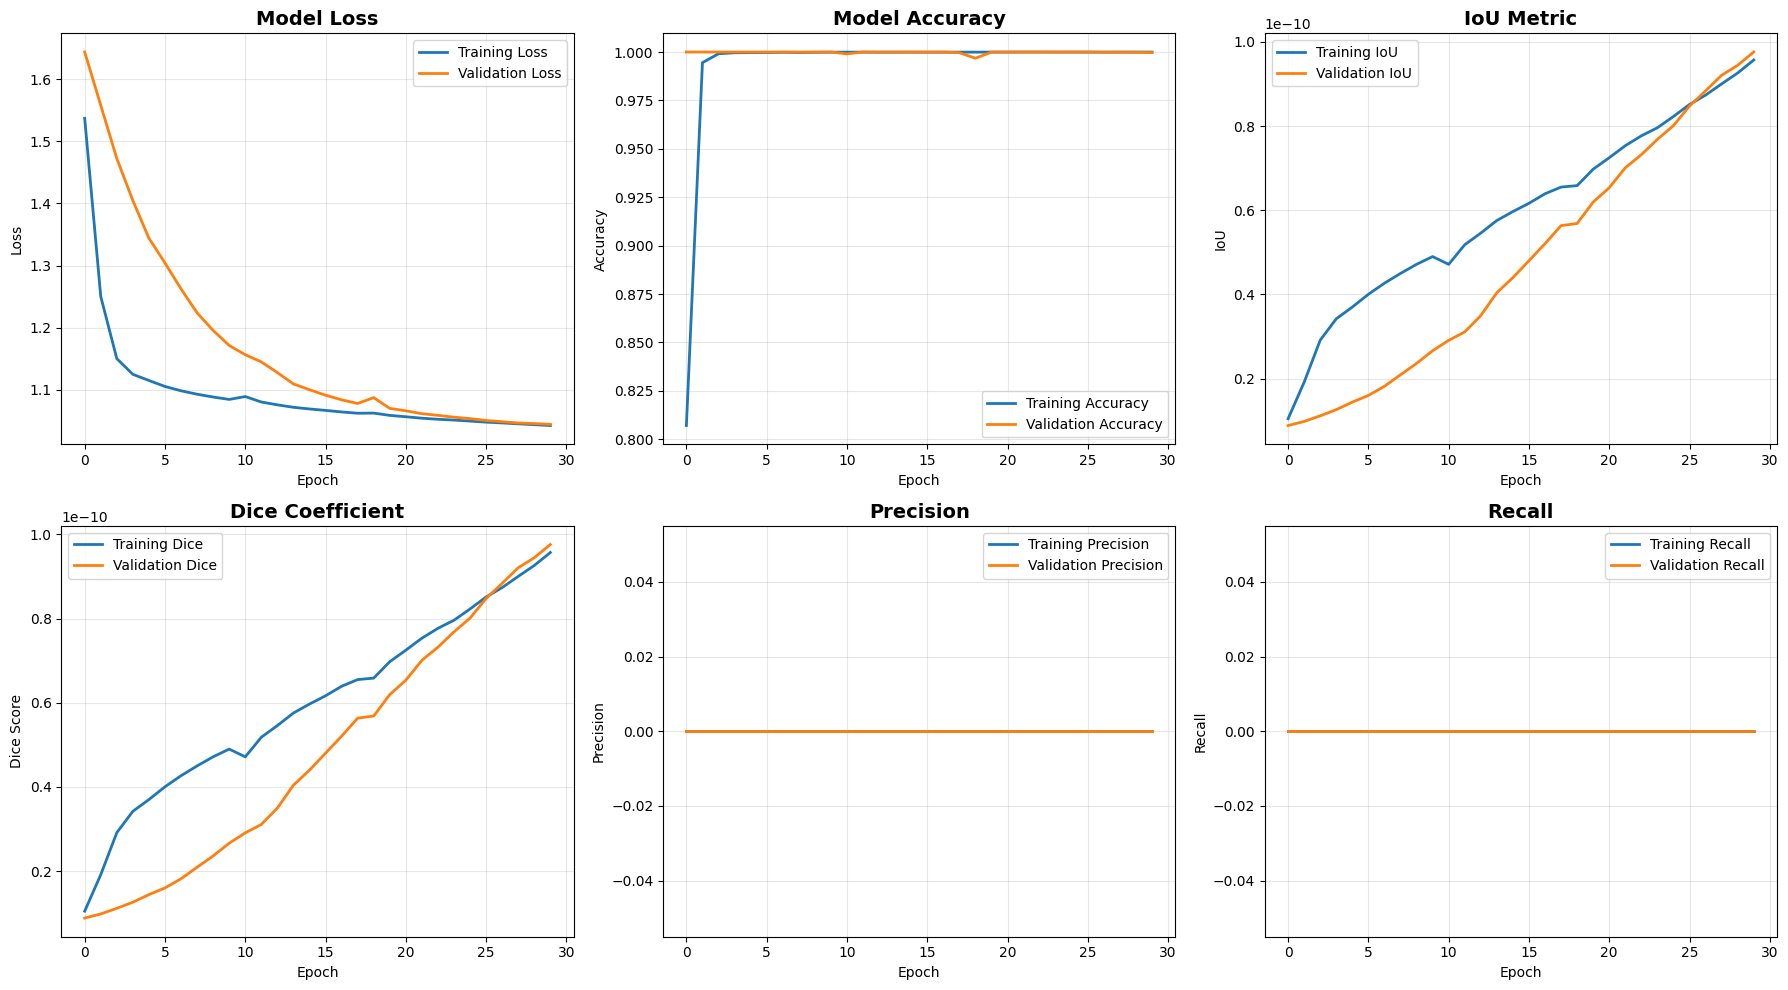

In [ ]:
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Loss
    axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0, 1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # IoU
    axes[0, 2].plot(history.history['iou_metric'], label='Training IoU', linewidth=2)
    axes[0, 2].plot(history.history['val_iou_metric'], label='Validation IoU', linewidth=2)
    axes[0, 2].set_title('IoU Metric', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('IoU')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Dice Coefficient
    axes[1, 0].plot(history.history['dice_coefficient'], label='Training Dice', linewidth=2)
    axes[1, 0].plot(history.history['val_dice_coefficient'], label='Validation Dice', linewidth=2)
    axes[1, 0].set_title('Dice Coefficient', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Dice Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Precision
    axes[1, 1].plot(history.history['precision'], label='Training Precision', linewidth=2)
    axes[1, 1].plot(history.history['val_precision'], label='Validation Precision', linewidth=2)
    axes[1, 1].set_title('Precision', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Precision')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Recall
    axes[1, 2].plot(history.history['recall'], label='Training Recall', linewidth=2)
    axes[1, 2].plot(history.history['val_recall'], label='Validation Recall', linewidth=2)
    axes[1, 2].set_title('Recall', fontsize=14, fontweight='bold')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Recall')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

## 13. Visualize Training History

In [ ]:
# Evaluate on test set
print("="*50)
print("Evaluating on Test Set...")
print("="*50)

test_results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=1)

print("\n" + "="*50)
print("Test Set Results:")
print("="*50)
metric_names = ['Loss', 'Accuracy', 'IoU', 'Dice Coefficient', 'Precision', 'Recall']
for name, value in zip(metric_names, test_results):
    print(f"  {name:20s}: {value:.4f}")
print("="*50)

Evaluating on Test Set...
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 830ms/step - accuracy: 1.0000 - dice_coefficient: 9.7687e-11 - iou_metric: 9.7687e-11 - loss: 1.0440 - precision: 0.0000e+00 - recall: 0.0000e+00

Test Set Results:
  Loss                : 1.0440
  Accuracy            : 1.0000
  IoU                 : 0.0000
  Dice Coefficient    : 0.0000
  Precision           : 0.0000
  Recall              : 0.0000
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 830ms/step - accuracy: 1.0000 - dice_coefficient: 9.7687e-11 - iou_metric: 9.7687e-11 - loss: 1.0440 - precision: 0.0000e+00 - recall: 0.0000e+00

Test Set Results:
  Loss                : 1.0440
  Accuracy            : 1.0000
  IoU                 : 0.0000
  Dice Coefficient    : 0.0000
  Precision           : 0.0000
  Recall              : 0.0000


## 14. Load Best Model

In [ ]:
# Make predictions
print("Generating predictions on test set...")
y_pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=1)

# Binarize predictions (threshold = 0.5)
y_pred_binary = (y_pred > 0.5).astype(np.float32)

print(f"\n✓ Predictions generated!")
print(f"  Predictions shape: {y_pred.shape}")
print(f"  Prediction range: [{y_pred.min():.4f}, {y_pred.max():.4f}]")

Generating predictions on test set...
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 855ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 855ms/step

✓ Predictions generated!
  Predictions shape: (199, 128, 128, 1)
  Prediction range: [0.0111, 0.3004]

✓ Predictions generated!
  Predictions shape: (199, 128, 128, 1)
  Prediction range: [0.0111, 0.3004]


## 15. Make Predictions on Test Set

Test Set Predictions:


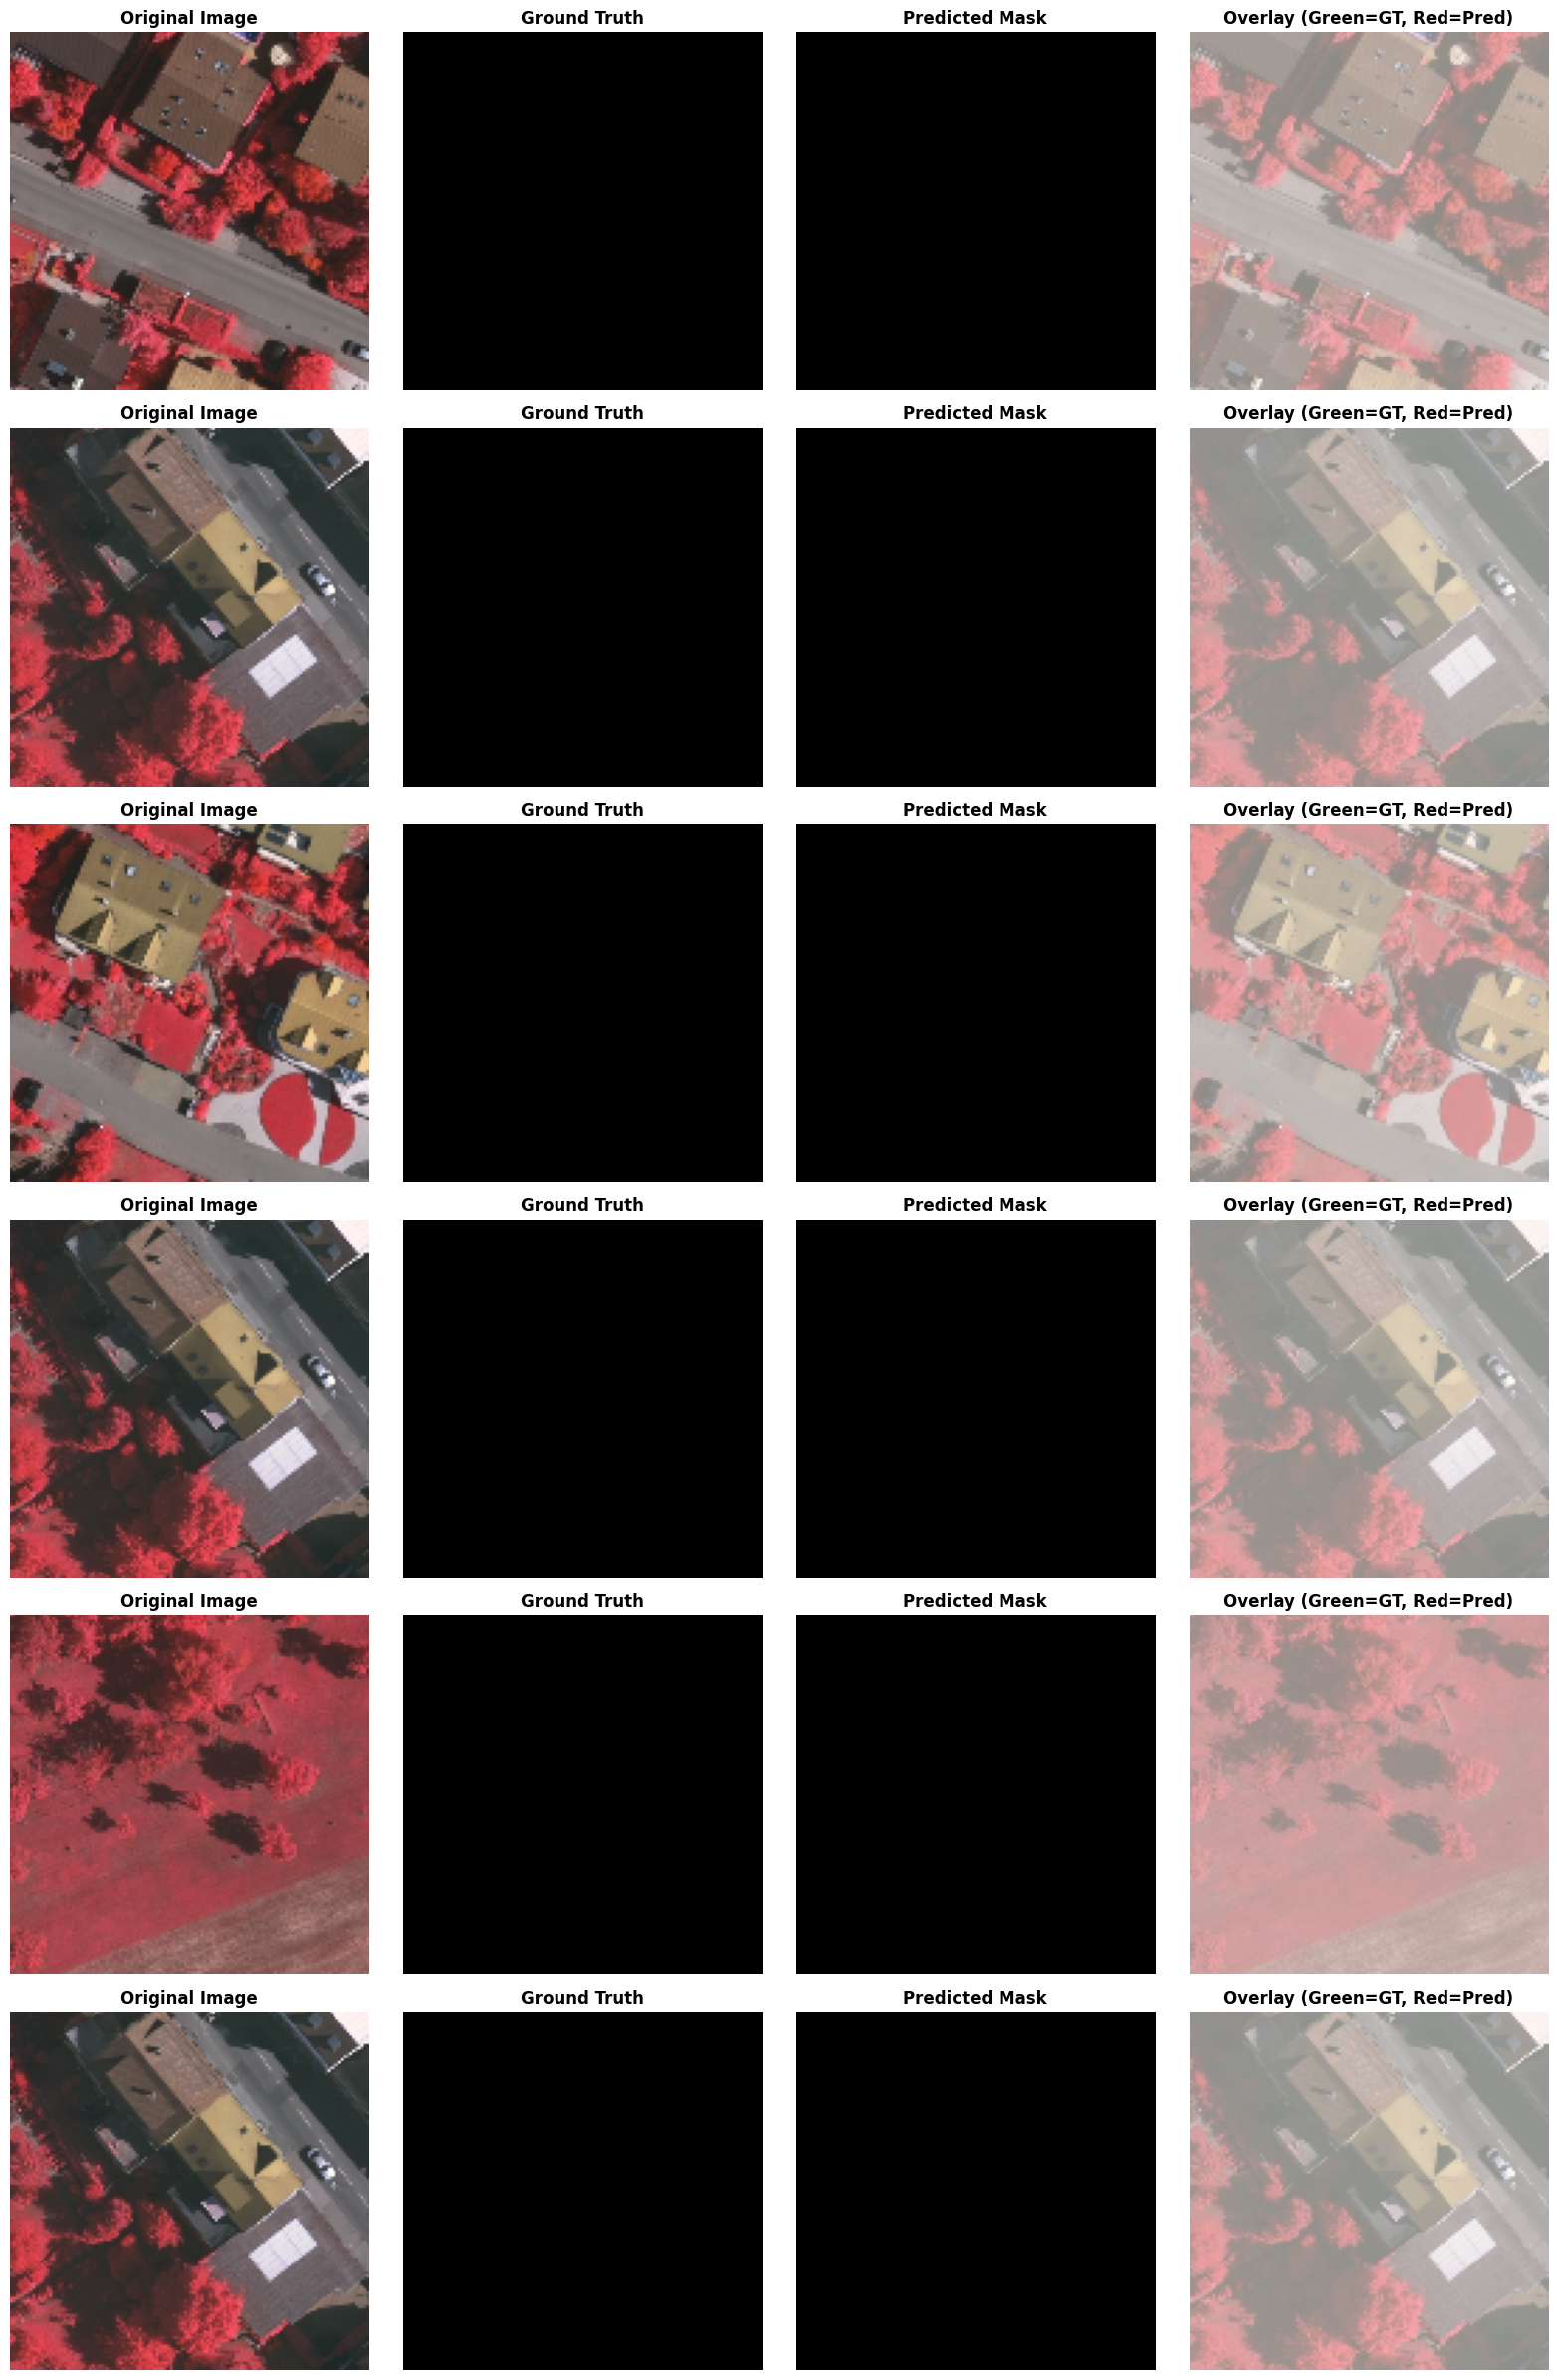

In [ ]:
def visualize_predictions(images, true_masks, pred_masks, num_samples=6):
    """Visualize original images, ground truth, and predictions"""
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    
    for i in range(num_samples):
        idx = np.random.randint(0, len(images))
        
        # Original Image
        axes[i, 0].imshow(images[idx])
        axes[i, 0].set_title('Original Image', fontsize=12, fontweight='bold')
        axes[i, 0].axis('off')
        
        # Ground Truth
        axes[i, 1].imshow(true_masks[idx].squeeze(), cmap='gray')
        axes[i, 1].set_title('Ground Truth', fontsize=12, fontweight='bold')
        axes[i, 1].axis('off')
        
        # Predicted Mask
        axes[i, 2].imshow(pred_masks[idx].squeeze(), cmap='gray')
        axes[i, 2].set_title('Predicted Mask', fontsize=12, fontweight='bold')
        axes[i, 2].axis('off')
        
        # Overlay Comparison
        axes[i, 3].imshow(images[idx])
        axes[i, 3].imshow(true_masks[idx].squeeze(), alpha=0.3, cmap='Greens')
        axes[i, 3].imshow(pred_masks[idx].squeeze(), alpha=0.3, cmap='Reds')
        axes[i, 3].set_title('Overlay (Green=GT, Red=Pred)', fontsize=12, fontweight='bold')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Test Set Predictions:")
visualize_predictions(X_test, y_test, y_pred_binary, num_samples=6)

## 16. Visualize Predictions

In [ ]:
def calculate_metrics_per_image(y_true, y_pred, smooth=1e-6):
    """Calculate IoU and Dice for each image"""
    iou_scores = []
    dice_scores = []
    
    for i in range(len(y_true)):
        true_flat = y_true[i].flatten()
        pred_flat = y_pred[i].flatten()
        
        # IoU
        intersection = np.sum(true_flat * pred_flat)
        union = np.sum(true_flat) + np.sum(pred_flat) - intersection
        iou = (intersection + smooth) / (union + smooth)
        iou_scores.append(iou)
        
        # Dice
        dice = (2. * intersection + smooth) / (np.sum(true_flat) + np.sum(pred_flat) + smooth)
        dice_scores.append(dice)
    
    return np.array(iou_scores), np.array(dice_scores)

# Calculate per-image metrics
iou_scores, dice_scores = calculate_metrics_per_image(y_test, y_pred_binary)

print("="*50)
print("Per-Image Metrics on Test Set:")
print("="*50)
print(f"Mean IoU:        {np.mean(iou_scores):.4f} ± {np.std(iou_scores):.4f}")
print(f"Median IoU:      {np.median(iou_scores):.4f}")
print(f"Min IoU:         {np.min(iou_scores):.4f}")
print(f"Max IoU:         {np.max(iou_scores):.4f}")
print()
print(f"Mean Dice:       {np.mean(dice_scores):.4f} ± {np.std(dice_scores):.4f}")
print(f"Median Dice:     {np.median(dice_scores):.4f}")
print(f"Min Dice:        {np.min(dice_scores):.4f}")
print(f"Max Dice:        {np.max(dice_scores):.4f}")
print("="*50)

Per-Image Metrics on Test Set:
Mean IoU:        1.0000 ± 0.0000
Median IoU:      1.0000
Min IoU:         1.0000
Max IoU:         1.0000

Mean Dice:       1.0000 ± 0.0000
Median Dice:     1.0000
Min Dice:        1.0000
Max Dice:        1.0000


## 17. Calculate Final Metrics

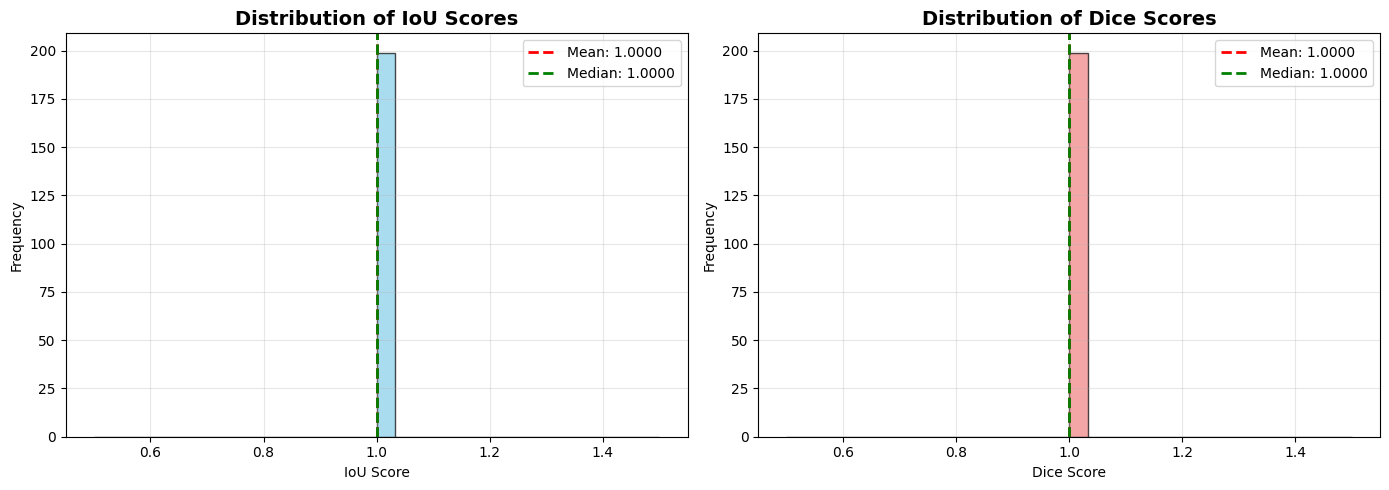

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# IoU Distribution
axes[0].hist(iou_scores, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(iou_scores), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(iou_scores):.4f}')
axes[0].axvline(np.median(iou_scores), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(iou_scores):.4f}')
axes[0].set_title('Distribution of IoU Scores', fontsize=14, fontweight='bold')
axes[0].set_xlabel('IoU Score')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Dice Distribution
axes[1].hist(dice_scores, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].axvline(np.mean(dice_scores), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(dice_scores):.4f}')
axes[1].axvline(np.median(dice_scores), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(dice_scores):.4f}')
axes[1].set_title('Distribution of Dice Scores', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Dice Score')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 18. Advanced Visualization - Overlay Predictions

Best Predictions (Highest IoU):


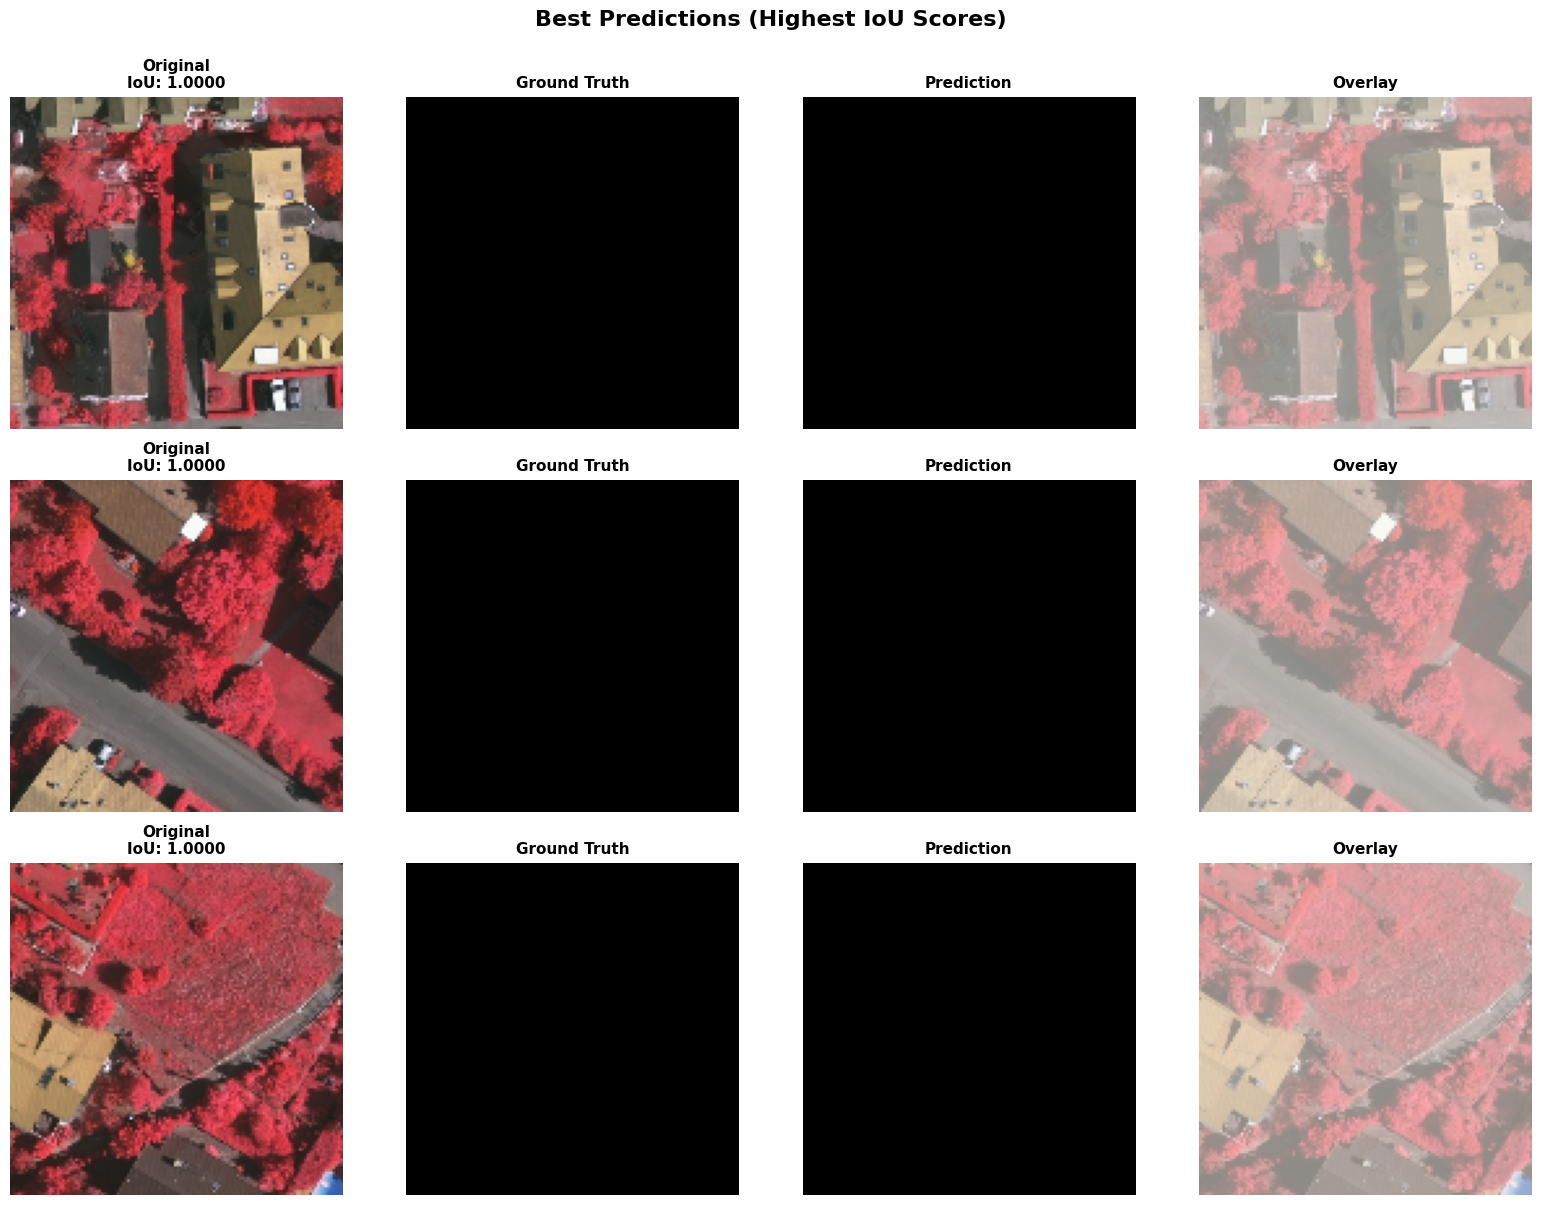


Worst Predictions (Lowest IoU):


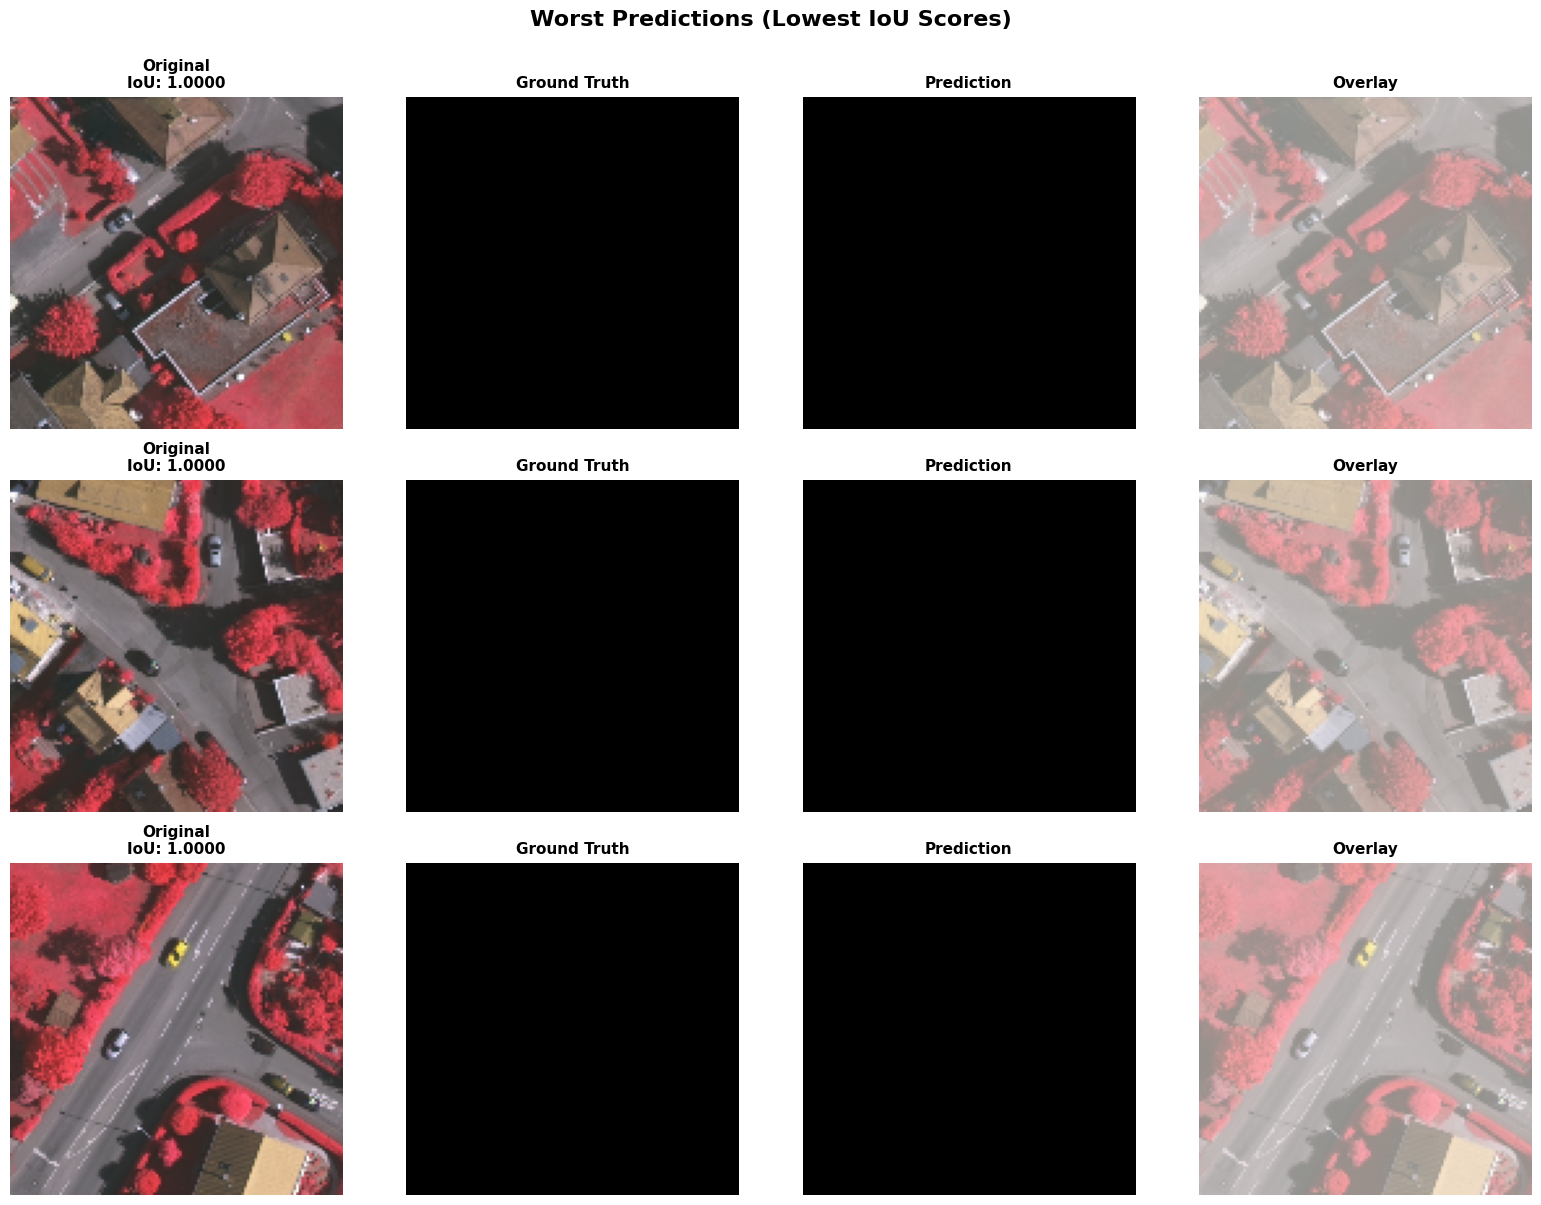

In [ ]:
# Find best and worst predictions based on IoU
best_indices = np.argsort(iou_scores)[-3:][::-1]  # Top 3
worst_indices = np.argsort(iou_scores)[:3]  # Bottom 3

def show_best_worst(images, true_masks, pred_masks, indices, scores, title):
    """Display best or worst predictions"""
    fig, axes = plt.subplots(len(indices), 4, figsize=(16, 4*len(indices)))
    
    if len(indices) == 1:
        axes = axes.reshape(1, -1)
    
    for i, idx in enumerate(indices):
        # Original
        axes[i, 0].imshow(images[idx])
        axes[i, 0].set_title(f'Original\nIoU: {scores[idx]:.4f}', fontsize=11, fontweight='bold')
        axes[i, 0].axis('off')
        
        # Ground Truth
        axes[i, 1].imshow(true_masks[idx].squeeze(), cmap='gray')
        axes[i, 1].set_title('Ground Truth', fontsize=11, fontweight='bold')
        axes[i, 1].axis('off')
        
        # Prediction
        axes[i, 2].imshow(pred_masks[idx].squeeze(), cmap='gray')
        axes[i, 2].set_title('Prediction', fontsize=11, fontweight='bold')
        axes[i, 2].axis('off')
        
        # Overlay
        axes[i, 3].imshow(images[idx])
        axes[i, 3].imshow(true_masks[idx].squeeze(), alpha=0.3, cmap='Greens')
        axes[i, 3].imshow(pred_masks[idx].squeeze(), alpha=0.3, cmap='Reds')
        axes[i, 3].set_title('Overlay', fontsize=11, fontweight='bold')
        axes[i, 3].axis('off')
    
    fig.suptitle(title, fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

print("Best Predictions (Highest IoU):")
show_best_worst(X_test, y_test, y_pred_binary, best_indices, iou_scores, 
                'Best Predictions (Highest IoU Scores)')

print("\nWorst Predictions (Lowest IoU):")
show_best_worst(X_test, y_test, y_pred_binary, worst_indices, iou_scores, 
                'Worst Predictions (Lowest IoU Scores)')

## 19. Conclusion

### Key Takeaways:

1. **U-Net Architecture**: 
   - Powerful for semantic segmentation with its encoder-decoder structure
   - Skip connections preserve spatial information from downsampling

2. **Custom Metrics**:
   - **IoU (mIoU)**: Measures overlap between prediction and ground truth
   - **Dice Coefficient**: Similar to IoU but more sensitive to small objects
   - Combined BCE+Dice loss balances pixel-wise accuracy with spatial overlap

3. **Training Strategies**:
   - EarlyStopping prevents overfitting
   - ReduceLROnPlateau helps escape local minima
   - ModelCheckpoint saves best weights

4. **Performance Tips**:
   - Data augmentation can improve generalization
   - Experiment with different loss functions
   - Monitor both training and validation metrics

5. **Real-World Applications**:
   - Medical image segmentation (tumors, organs)
   - Satellite imagery analysis (buildings, roads)
   - Autonomous driving (lane detection, object boundaries)

## 20. Save and Load Model

In [ ]:
# Save the entire model
model.save('unet_segmentation_final.h5')
print("✓ Model saved as 'unet_segmentation_final.h5'")

# To load the model later:
# from tensorflow import keras
# loaded_model = keras.models.load_model(
#     'unet_segmentation_final.h5',
#     custom_objects={
#         'bce_dice_loss': bce_dice_loss,
#         'iou_metric': iou_metric,
#         'dice_coefficient': dice_coefficient
#     }
# )



✓ Model saved as 'unet_segmentation_final.h5'

Tutorial Complete! 🎉
You now know how to:
  ✓ Build U-Net architecture from scratch
  ✓ Implement custom IoU and Dice metrics
  ✓ Train semantic segmentation models
  ✓ Evaluate with multiple metrics
  ✓ Visualize segmentation results
